# 建立一个预测加州房价的模型 

## 数据读取

In [24]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [26]:
fetch_housing_data()

In [27]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [28]:
housing = load_housing_data()

## 查看数据概况

In [30]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [31]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [32]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

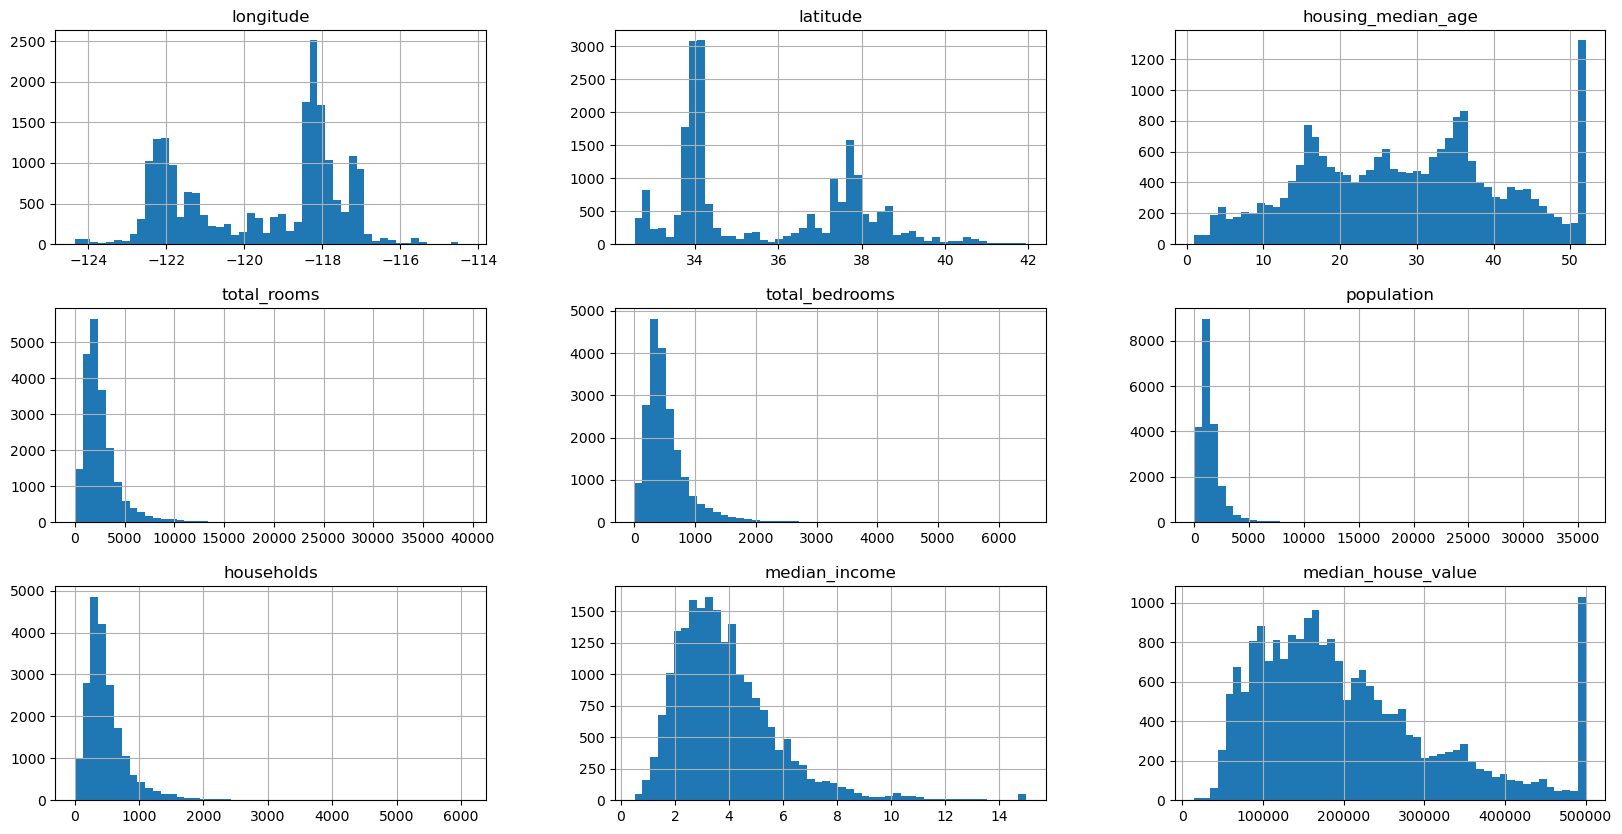

In [35]:
housing.hist(bins=50, figsize=(20,10))

## 划分数据集

### 针对不会有新增数据的数据集划分

In [43]:
# 针对不会有新增数据的数据集划分
import numpy as np

def split_train_test(data, test_ratio):
    # 为了使得每次随机的结果一样，需要设置随机种子
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data)) 
    test_set_size = int(test_ratio * len(data))
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
    

In [44]:
print(train_set.shape, test_set.shape)

(16512, 10) (4128, 10)


### 针对会有新增数据的数据集划分

In [58]:
# 针对会有新增数据的数据集划分，可以给每个样本打标签，来决定其是否进入测试集
# 一种方法是使用样本标识符的哈希值，哈希值<=阈值的全部放入测试集
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32 # &是按位运算


def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]  # ~是布尔取反

In [59]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

### 使用sklearn进行数据集的划分

In [63]:
# 使用sklearn进行数据集的划分
from  sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)

### 使用sklearn进行分层的数据集划分

In [65]:
# 使用sklearn进行分层的数据集划分
housing['income_cat'] = pd.cut(housing['median_income'], 
                               bins=[0., 1.5, 3.0, 4.5, 6., np.Inf],
                               labels=[1,2,3,4,5])

<AxesSubplot:>

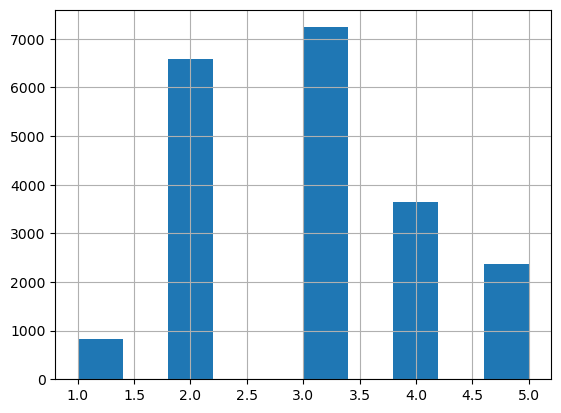

In [69]:
housing['income_cat'].hist()

In [72]:
from  sklearn.model_selection import StratifiedShuffleSplit
# n_splits指的是生成几个split的结果，返回实例
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# 调用实例的split方法，X是等待划分的数据， y是分层的参考值，返回生成器,生成器放回train和test的indices
# split.split(X=housing, y=housing['income_cat'])
# 因为设置n_splits=1,所以下面的循环只会执行一次
for train_index, test_index in split.split(X=housing, y=housing['income_cat']):
    strat_train_set = housing.iloc[train_index]
    strat_test_set = housing.iloc[test_index]

In [73]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,2
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,5
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,2
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,2
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,3
...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN,4
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND,2
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN,3
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN,3


In [75]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [76]:
housing['income_cat'].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

可以看到在分层划分的测试集上，数据的分布和总体的数据分布相同

In [ ]:
# 删除用于分层的列
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [80]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN


## 对训练集进行探索

### 可视化

In [82]:
# 创建副本进行探索以免损害训练集
housing = train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

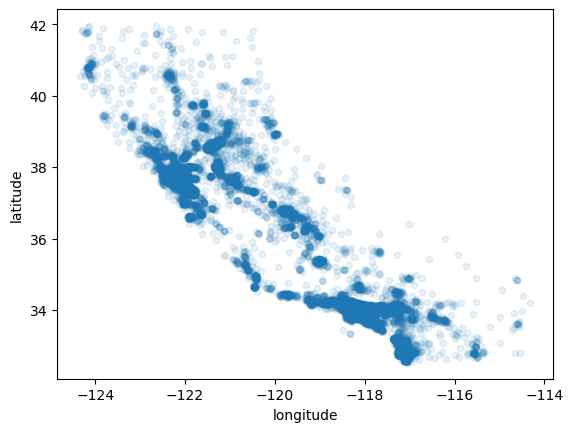

In [86]:
from matplotlib import pyplot as plt
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

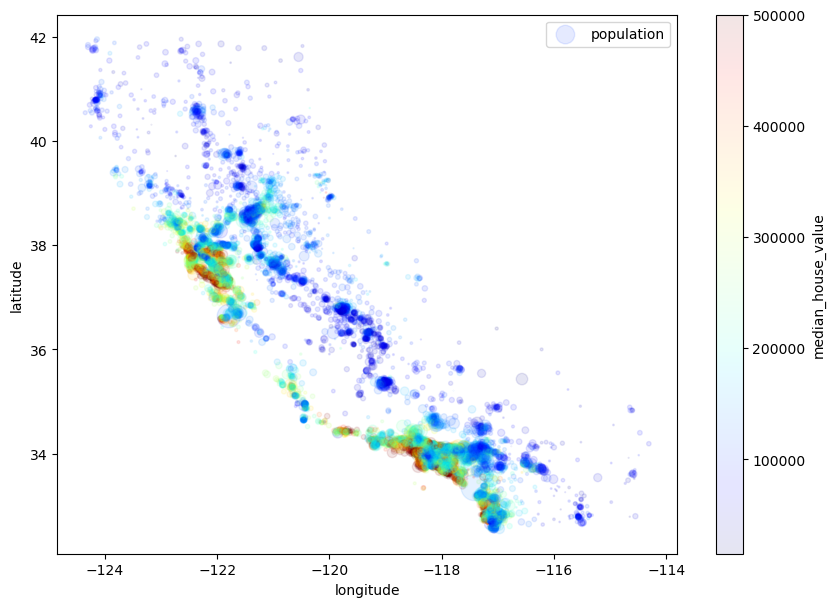

In [87]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1,
             s=housing["population"]/100, label="population", figsize=(10,7), 
             c="median_house_value", cmap=plt.get_cmap('jet'), colorbar=True)

### 寻找属性间的相关性

In [88]:
corr_matrix = housing.corr()

In [89]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

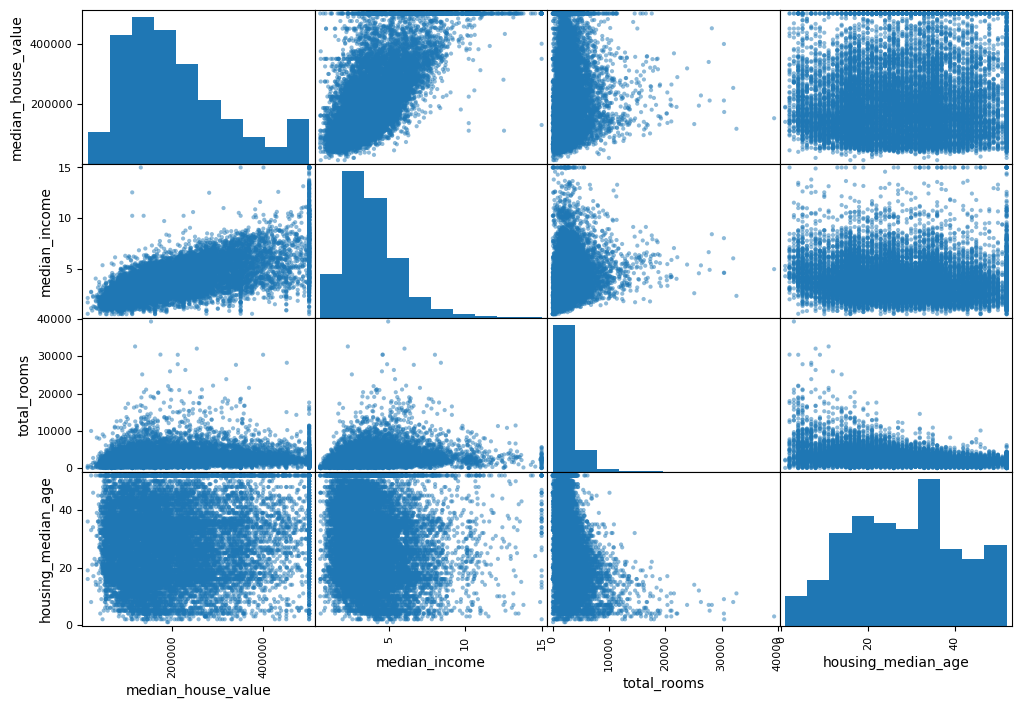

In [91]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

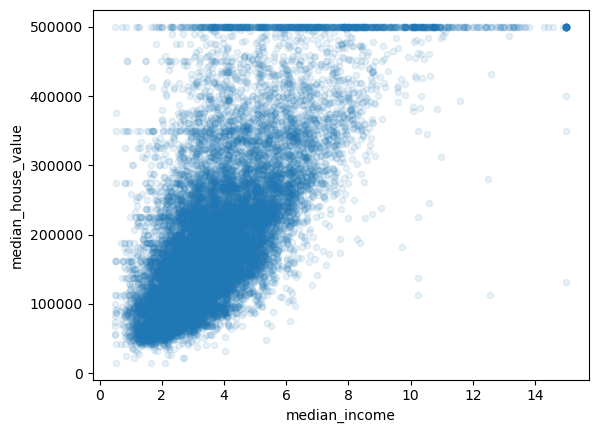

In [94]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

### 实验不同的属性组合，产生新的feature 

In [95]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [99]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690647
rooms_per_household         0.158485
total_rooms                 0.133989
housing_median_age          0.103706
households                  0.063714
total_bedrooms              0.047980
population_per_household   -0.022030
population                 -0.026032
longitude                  -0.046349
latitude                   -0.142983
bedrooms_per_room          -0.257419
Name: median_house_value, dtype: float64

可以看到新添加的rooms_per_household比其他一些原有的属性都要好

数据探索不要多么彻底，这是不断迭代的过程

## 为机器学习算法准备数据

In [102]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### 数据清理

对于缺失值有3种处理方法：
1. 丢弃样本
2. 丢弃属性
3. 缺失值填充（0、平均数、中位数）

In [106]:
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

In [107]:
# 使用sklearn处理缺失值
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

In [108]:
# 由于中位数只能在数值型数据上计算，所以先去除字符型属性
housing_num = housing.drop('ocean_proximity', axis=1)

In [110]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [111]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [112]:
X = imputer.transform(housing_num)

In [113]:
X

array([[-1.2146e+02,  3.8520e+01,  2.9000e+01, ...,  2.2370e+03,
         7.0600e+02,  2.1736e+00],
       [-1.1723e+02,  3.3090e+01,  7.0000e+00, ...,  2.0150e+03,
         7.6800e+02,  6.3373e+00],
       [-1.1904e+02,  3.5370e+01,  4.4000e+01, ...,  6.6700e+02,
         3.0000e+02,  2.8750e+00],
       ...,
       [-1.2272e+02,  3.8440e+01,  4.8000e+01, ...,  4.5800e+02,
         1.7200e+02,  3.1797e+00],
       [-1.2270e+02,  3.8310e+01,  1.4000e+01, ...,  1.2080e+03,
         5.0100e+02,  4.1964e+00],
       [-1.2214e+02,  3.9970e+01,  2.7000e+01, ...,  6.2500e+02,
         1.9700e+02,  3.1319e+00]])

In [114]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [115]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


sklearn:
1. 估算器：根据数据集对某些参数进行估计，方法：fit()
2. 转换器：用于转换数据集的估算器，方法：transform(), fit_transform()
3. 预测器：基于给定数据集进行预测，方法：predict()， score()

### 对于文本属性采用编号encode

In [122]:
housing_cat = housing[['ocean_proximity']] # 这样输出的是df,去掉一个[]则是series

In [123]:
housing_cat

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
...,...
15174,<1H OCEAN
12661,INLAND
19263,<1H OCEAN
19140,<1H OCEAN


In [124]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
house_cat_encoded = ordinal_encoder.fit_transform(housing_cat)


In [127]:
house_cat_encoded

array([[1.],
       [4.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

In [129]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

对于文本属性采用one-hot encode

In [130]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
house_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [131]:
house_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [133]:
house_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [134]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

关于自定义转换器：
创建一个类，完成以下3个方法：
1. fit()，返回self
2. transform()
3. fit_transform()
若以TransformerMixin作为基类，可以不用定义fit_transform；
若以BaseEstimator作为基类，且在__init__中不使用*args,**kargs，则可以获得两个超参数自动调整方法get_params(), set_params()


In [139]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombineAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self # do nothing
    
    def transform(self, X):
        rooms_per_household = X[:, room_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[rooms_per_household, population_per_household]

attr_adder = CombineAttributesAdder()
housing_extra_attribs = attr_adder.transform(housing.values)

In [140]:
housing_extra_attribs

array([[5.485835694050992, 3.168555240793201, 0.20578363026077975],
       [6.927083333333333, 2.6236979166666665, 0.16071428571428573],
       [5.3933333333333335, 2.223333333333333, 0.1915945611866502],
       ...,
       [4.1104651162790695, 2.6627906976744184, 0.2347949080622348],
       [6.297405189620759, 2.411177644710579, 0.1838351822503962],
       [5.477157360406092, 3.1725888324873095, 0.2057460611677479]],
      dtype=object)

### 特征缩放

1. 归一化(Normalizer)
2. 标准化 (StandardScaler)

`注意：所有的转换器都在仅在训练集上进行fit，再丢到测试集、新数据上运行`

### 转换流水线pipeline

- pipeline的最后一个组件可以是转换器，也可以是估算器，但前面的所有组件都必须是转换器

- 流水线的方法与最终组件的方法相同
- 如果pipeline的最后一个组件只是一个估算器，则只能调用fit()，调用后前面的每个转换器会自动调用fit_transform()
- 如果最后一个组件时一个转换器,则可以调用fit_transform()或者fit()+transform()

In [143]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('Kian_imputer', SimpleImputer(strategy='median')), # 命名可以随意
    ('attr_adder', CombineAttributesAdder()),
    ('std_scaler', StandardScaler())
])

# 只处理数值型属性
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [144]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


### 同时处理数值型和文本型属性

pipeline种未列出的列默认被删除   
也可以指定"drop"为名称显式删除   
如果保持列不变，则使用"passthrough"   
或者设置reminder超参数为"passthrough"

In [145]:
from sklearn.compose import ColumnTransformer 

In [148]:
num_attribs = list(housing_num) # 直接得到columns
cat_attribs = ['ocean_proximity']
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing)

In [160]:
housing_prepared[0]

array([ 0.01739526,  0.00622264, -0.12112176,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ])

## 选择并训练模型 

In [161]:
from sklearn.linear_model import LinearRegression

In [162]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [164]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("pred:", lin_reg.predict(some_data_prepared))
print('labels:', list(some_labels))

pred: [121468.64788991 283598.45187521 126909.63592196 216308.67791146
 261813.61582043]
labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [165]:
# 评估训练效果
from sklearn.metrics import mean_squared_error
housing_pred = lin_reg.predict(housing_prepared)
lin_mes = mean_squared_error(housing_labels, housing_pred)
lin_rmes = np.sqrt(lin_mes)
lin_rmes

94521.09457084945

可以看到欠拟合很严重，
1. 可能是模型不够强
2. 需要新增更好的feature

In [166]:
# 使用决策树回归
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [169]:
housing_pred = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

上述结果可能因为严重过拟合了，为了确定使用验证机进行计算rmse    
（在有信心启动模型之前都不要碰测试集）

## 使用交叉验证进行验证集评估

sklearn的交叉验证功能倾向于使用效用函数，所以下面的error加负号

In [172]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [173]:
tree_rmse_scores

array([102601.59048434, 104979.00527134, 104860.28640755, 104842.78748683,
       101511.24308895, 109802.62255132, 106431.66736452, 105713.97503263,
       105717.93749807, 106948.62861383])

In [174]:
tree_rmse_scores.mean()

105340.97437993865

In [175]:
tree_rmse_scores.std()

2162.0138075056507

In [177]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [178]:
lin_rmse_scores

array([ 94426.78662098,  93100.1671735 ,  93436.93282249,  96017.41512664,
        93286.41472578,  97760.77395214, 101325.29391979,  92310.1546358 ,
        93826.91967853,  94415.46207101])

In [180]:
lin_rmse_scores.mean()

94990.63207266477

In [181]:
lin_rmse_scores.std()

2587.199913036142

In [182]:
# 使用随机森林模型
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [184]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [185]:
forest_rmse_scores

array([77036.4167218 , 77246.68558577, 74029.42911937, 80007.47398541,
       74864.49462394, 80278.32202668, 77986.35418777, 77249.78260717,
       75177.40461476, 80020.79820569])

In [186]:
forest_rmse_scores.mean()

77389.71616783628

In [187]:
forest_rmse_scores.std()

2126.0932332582483

In [190]:
forest_pred = forest_reg.predict(housing_prepared)

In [192]:
print(np.sqrt(mean_squared_error(housing_labels, forest_pred)))

28904.33675530888


可以看到训练集上的误差比验证集上的小很多，说明存在过拟合    
解决方法：
1. 简化模型
2. 约束模型

`注意：选择模型阶段，不要花太多时间调整超参数，我们的目的是筛选出2-5个有效的模型`